# How to perform change of basis with translation

* https://youtu.be/P2LTAUO1TdA?t=340, however...
* We're dealing with affine spaces, not vector spaces, so we don't deal with vectors, but with affine frames (vector+origin)!
* https://stackoverflow.com/questions/69396507/programmatical-change-of-basis-for-coordinate-vectors-with-different-origin-of-c

## Preparation

In [1]:
import numpy as np
from sklearn import svm
from sklearn.datasets import make_blobs
import plotly.express as px
import plotly.graph_objects as go
import math
from dataclasses import dataclass

In [34]:
class ThreeDFigure():
    def __init__(self, trafo_fn=None, back_trafo_fn=None, swap_axes=None):
        self.trafo_fn = trafo_fn if trafo_fn is not None else lambda x: x
        self.back_trafo_fn = back_trafo_fn if back_trafo_fn is not None else lambda x: x
        self.swap_axes = swap_axes
        #https://community.plotly.com/t/creating-a-3d-scatterplot-with-equal-scale-along-all-axes/15108/7
        self.fig = go.Figure(layout=go.Layout(
                        scene=dict(camera=dict(eye=dict(x=1, y=1, z=1)), aspectmode="data"),
                        autosize=True,
                        width=1000,
                        height=800,
                        margin=dict(l=10, r=10, b=10, t=10, pad=4),
                        paper_bgcolor="White"))
        
    def _transform(self, points, inverse=False):
        trafo_fn = self.back_trafo_fn if inverse else self.trafo_fn              
        points = np.array([trafo_fn(point) for point in points])        
        if self.swap_axes:
            swap_translate = {"x": 0, "y": 1, "z": 2}
            ind1, ind2 = swap_translate[self.swap_axes[0]], swap_translate[self.swap_axes[1]]
            tmp = points[:,ind1].copy()
            points[:,ind1] = points[:,ind2]
            points[:,ind2] = tmp
        return points
                    
    def add_surface(self, x, y, z_func):
        xy_arr = np.vstack([xx.flatten(), yy.flatten()]).T
        z_arr = np.array([z_func(*i) for i in xy_arr])
        points = np.column_stack([xy_arr, z_arr])
        points = self._transform(points)
        surface_form = lambda x: x.reshape(round(math.sqrt(x.shape[0])),-1)
        self.fig.add_trace(go.Surface(x=surface_form(points[:,0]), y=surface_form(points[:,1]), z=surface_form(points[:,2])))
    
    
    def add_line(self, point1, point2, width=6, do_transform=True):
        if do_transform:
            point1 = self._transform(np.array([point1])).squeeze()
            point2 = self._transform(np.array([point2])).squeeze()
        self.fig.add_trace(
            go.Scatter3d(x = [point1[0], point2[0]],
                         y = [point1[1], point2[1]],
                         z = [point1[2], point2[2]],
                         marker = dict(size = 1),
                         line = dict(width = width)
                         )
        )
        
    def add_markers(self, points, color="black", size=2):
        points = np.array(points)
        if points.ndim == 1: points = np.array([points])
        points = self._transform(points)
        
        self.fig.add_trace(
            go.Scatter3d(
                mode='markers',
                x=points[:,0],
                y=points[:,1],
                z=points[:,2],
                marker={"color": color,
                        "size": size,
                        "line": {"width": 0}
                       },
            )
        )
    
    def __enter__(self, *args):
        return self
    
    def __exit__(self, *args):
        display(self.fig)
    

def make_meshgrid(X=None, minx=None, miny=None, maxx=None, maxy=None, size=None, amount=30, margin=0):
    assert X is not None or (minx is not None and miny is not None and maxx is not None and maxy is not None) or size is not None
    if X is not None:
        minx = min(X[:,0]) if minx is None or min(X[:,0])<minx else minx
        miny = min(X[:,1]) if miny is None or min(X[:,1])<miny else miny
        maxx = max(X[:,0]) if maxx is None or max(X[:,0])>maxx else maxx
        maxy = max(X[:,1]) if maxy is None or max(X[:,1])>maxy else maxy
    elif size is not None and (minx is None and miny is None and maxx is None and maxy is None):
        minx = miny = -size
        maxx = maxy = size
    lsx = np.linspace(minx-margin, maxx+margin, amount)
    lsy = np.linspace(miny-margin, maxy+margin, amount)
    xx, yy = np.meshgrid(lsx,lsy)
    return xx, yy

## Without Change-of-Basis

Coefficients: [[-0.13241591  0.3386556  -0.63863185]] Intercept: [0.42649677]


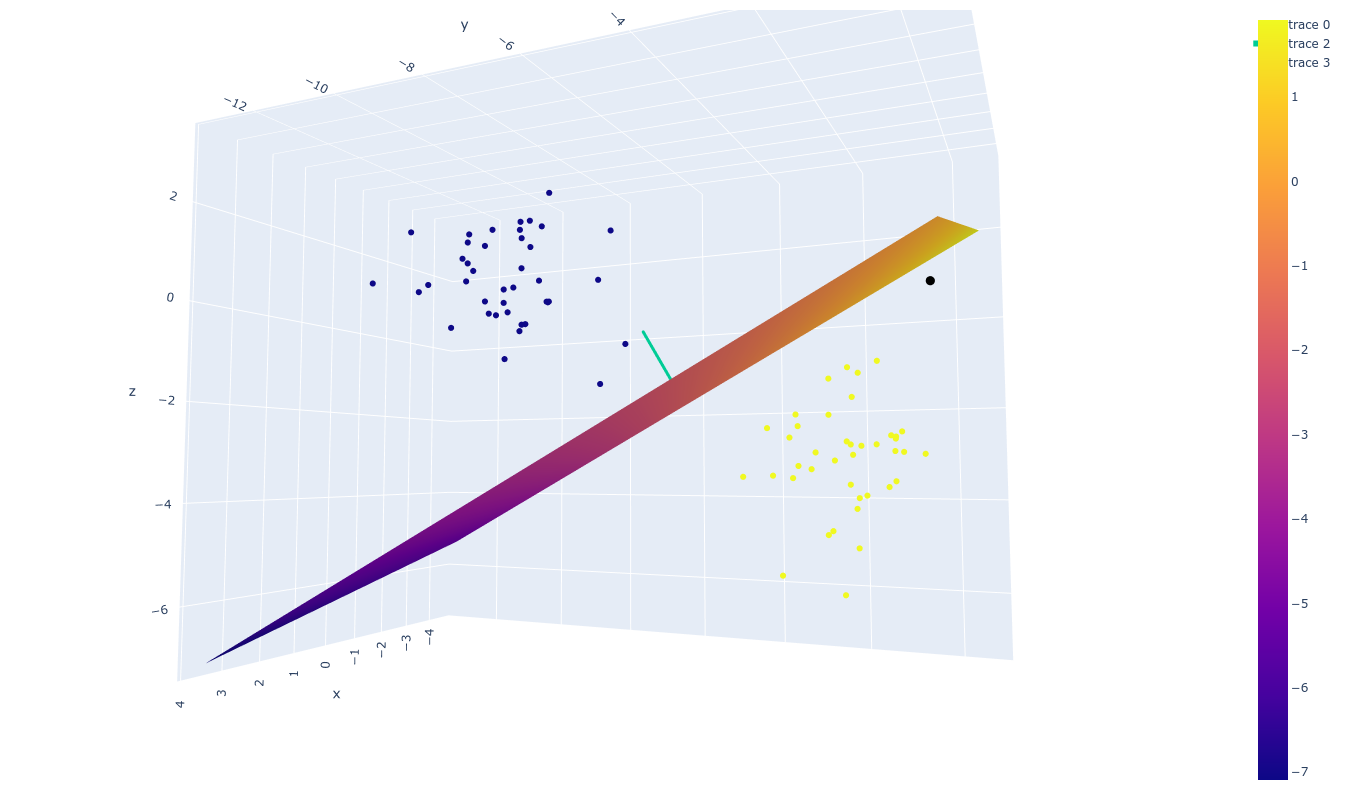

In [31]:
X, y = make_blobs(n_samples=80, centers=2, random_state=2, n_features=3)
model = svm.LinearSVC(C=1, max_iter=10000).fit(X, y)
print("Coefficients:", model.coef_, "Intercept:", model.intercept_)

decision_plane = Plane(*model.coef_[0], model.intercept_[0])

with ThreeDFigure() as fig:
    fig.add_markers(X, color=y) #samples
    xx, yy = make_meshgrid(X, margin=1)
    fig.add_surface(xx, yy, decision_plane.z) #decision hyperplane
    fig.add_line(X.mean(axis=0)-decision_plane.normal, X.mean(axis=0)+decision_plane.normal) #orthogonal of decision hyperplane through mean of points
    fig.add_markers([0,0,0], size=3) #coordinate center

## With change of Basis:

## Incorrect:

* Problem: wir machen zwar basiswechsel, gehen aber davon aus dass der Ursprung an der gleichen Position ist Ebene hat den Intercept 0, geht also durch [0,0,0]. Das ist aber nicht so! Und in unserer Transformationsmatrix können wir das nicht ausdrücken, da trafomatrizen zum basiswechsel von affinen Vektrorräumen ausgehen, bei denen der urpsrung an der selben position ist. DAS HEIßT ZUSÄTZLICH zum basiswechsel mit matrizenmultiplikation müssen wir den punkt des neuen ursprugns draufrechnen. Und dieser Punkt ist IM ALTEN KOORDINATENSYSTEM intercept*orthongonalvektor.
* Zweiter Fehler: `[1, 0, z_func(uvec1, 1, 0)]` ist kein unitvector der die plane aufspannt (was heißen würde orthogonal zur normalen), sondern lediglich der vektor der von [0,0,0] auf einen more or less random punkt der ebene zeigt!
* ...das hier würde für d=0 aber klappen!

In [75]:
def generate_trafo_matrices(uvec1, z_func):
    normalize = lambda vec: vec/np.linalg.norm(vec)
    uvec2 = normalize(np.array([1, 0, z_func(uvec1, 1, 0)]))
    uvec3 = normalize(np.cross(uvec1, uvec2))
    back_trafo_matrix = np.array([uvec2, uvec3, uvec1]).T
    trafo_matrix = np.linalg.inv(back_trafo_matrix)
    return trafo_matrix, back_trafo_matrix

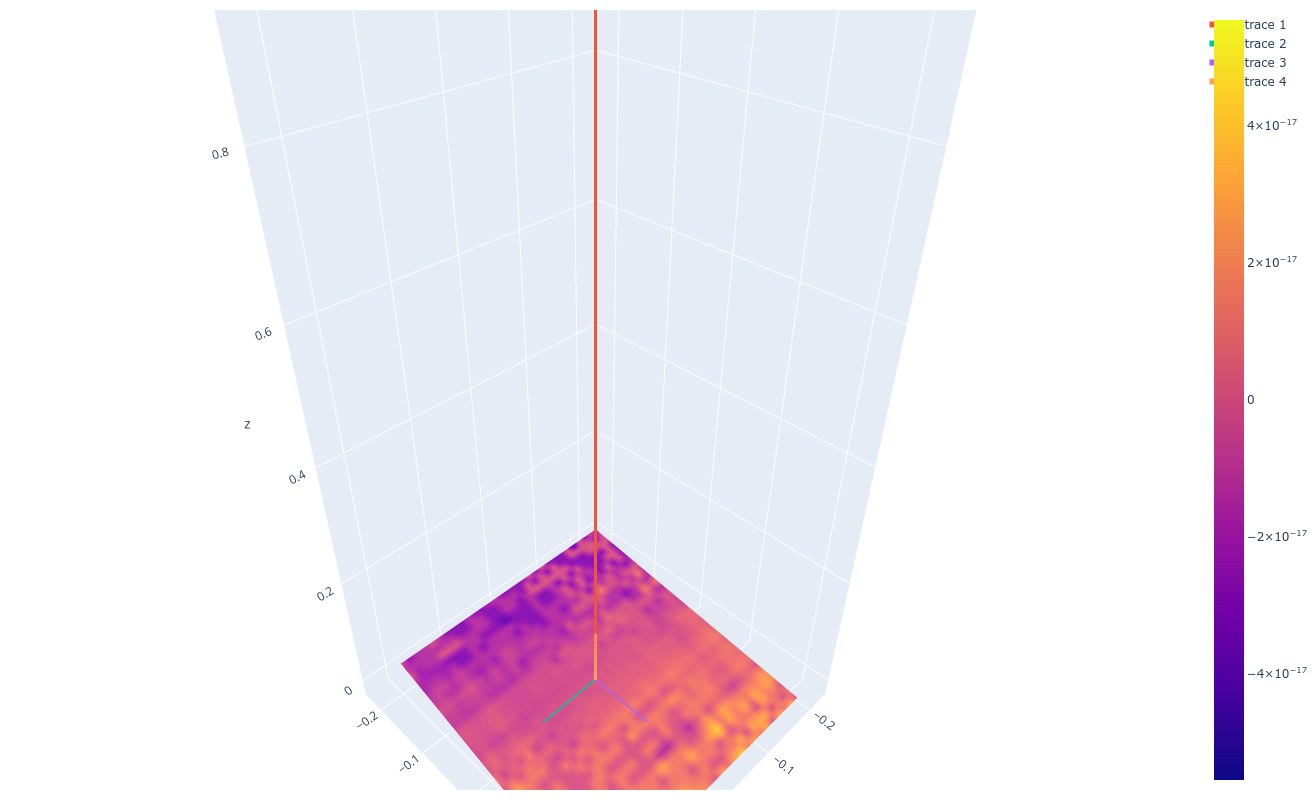

[[0. 0. 0.]]


In [76]:
vec, interc = np.array(model.coef_[0]), 0

plane_func = lambda vec, x,y: (-interc-vec[0]*x-vec[1]*y) / vec[2]

trafo_matrix, back_trafo_matrix = generate_trafo_matrices(vec, plane_func, interc)
xx, yy = make_meshgrid(size=0.2)

with ThreeDFigure(lambda x: np.dot(trafo_matrix, x), lambda x: np.dot(back_trafo_matrix, x)) as fig:
    fig.add_surface(xx, yy, lambda xx, yy: plane_func(vec,xx,yy))
    fig.add_line([0,0,0],vec)

    fig.add_line([0,0,0], fig._transform([[0.1,0,0]], inverse=True)[0])
    fig.add_line([0,0,0], fig._transform([[0,0.1,0]], inverse=True)[0])
    fig.add_line([0,0,0], fig._transform([[0,0,0.1]], inverse=True)[0])
    
print(fig._transform([[0,0,0]], inverse=True))

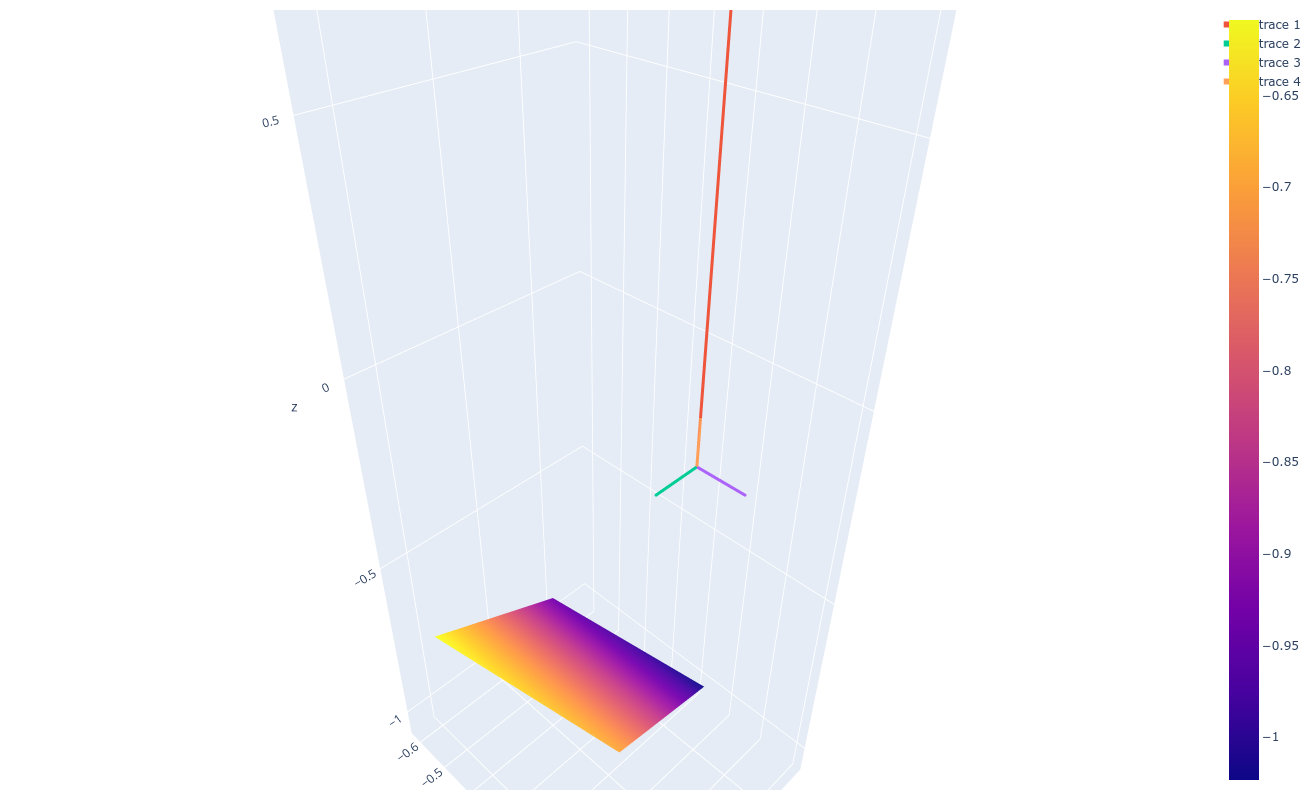

[[0. 0. 0.]]


In [77]:
vec, interc = np.array(model.coef_[0]), model.intercept_[0]

plane_func = lambda vec, x,y: (-interc-vec[0]*x-vec[1]*y) / vec[2]

trafo_matrix, back_trafo_matrix = generate_trafo_matrices(vec, plane_func, interc)
xx, yy = make_meshgrid(size=0.2)

with ThreeDFigure(lambda x: np.dot(trafo_matrix, x), lambda x: np.dot(back_trafo_matrix, x)) as fig:
    fig.add_surface(xx, yy, lambda xx, yy: plane_func(vec,xx,yy))
    fig.add_line([0,0,0],vec)

    fig.add_line([0,0,0], fig._transform([[0.1,0,0]], inverse=True)[0])
    fig.add_line([0,0,0], fig._transform([[0,0.1,0]], inverse=True)[0])
    fig.add_line([0,0,0], fig._transform([[0,0,0.1]], inverse=True)[0])
    
print(fig._transform([[0,0,0]], inverse=True))

## Correct:

In [29]:
@dataclass
class Plane:
    a: float
    b: float
    c: float
    d: float
    
    @property
    def normal(self):
        return np.array([self.a, self.b, self.c])
    
    def __contains__(self, point:np.array):
        return np.isclose(self.a*point[0] + self.b*point[1] + self.c*point[2] + self.d, 0)
    
    def project(self, point):
        x,y,z = point
        k = (self.a*x + self.b*y + self.c*z + self.d)/(self.a**2 + self.b**2 + self.c**2)
        return np.array([x - k*self.a, y-k*self.b, z-k*self.c])
   
    
    def z(self, x, y):
        return (- self.d - self.b*y - self.a*x)/self.c

def normalize(vec):
    return vec/np.linalg.norm(vec)

def make_base_changer(plane):
    uvec1 = plane.normal
    uvec2 = [0, -plane.d/plane.b, plane.d/plane.c]
    uvec3 = np.cross(uvec1, uvec2)
    transition_matrix = np.linalg.inv(np.array([uvec1, uvec2, uvec3]).T)
    
    origin = np.array([0,0,0])
    new_origin = plane.project(origin)
    forward  = lambda point: transition_matrix.dot(point - new_origin)
    backward = lambda point: np.linalg.inv(transition_matrix).dot(point) + new_origin
    return forward, backward

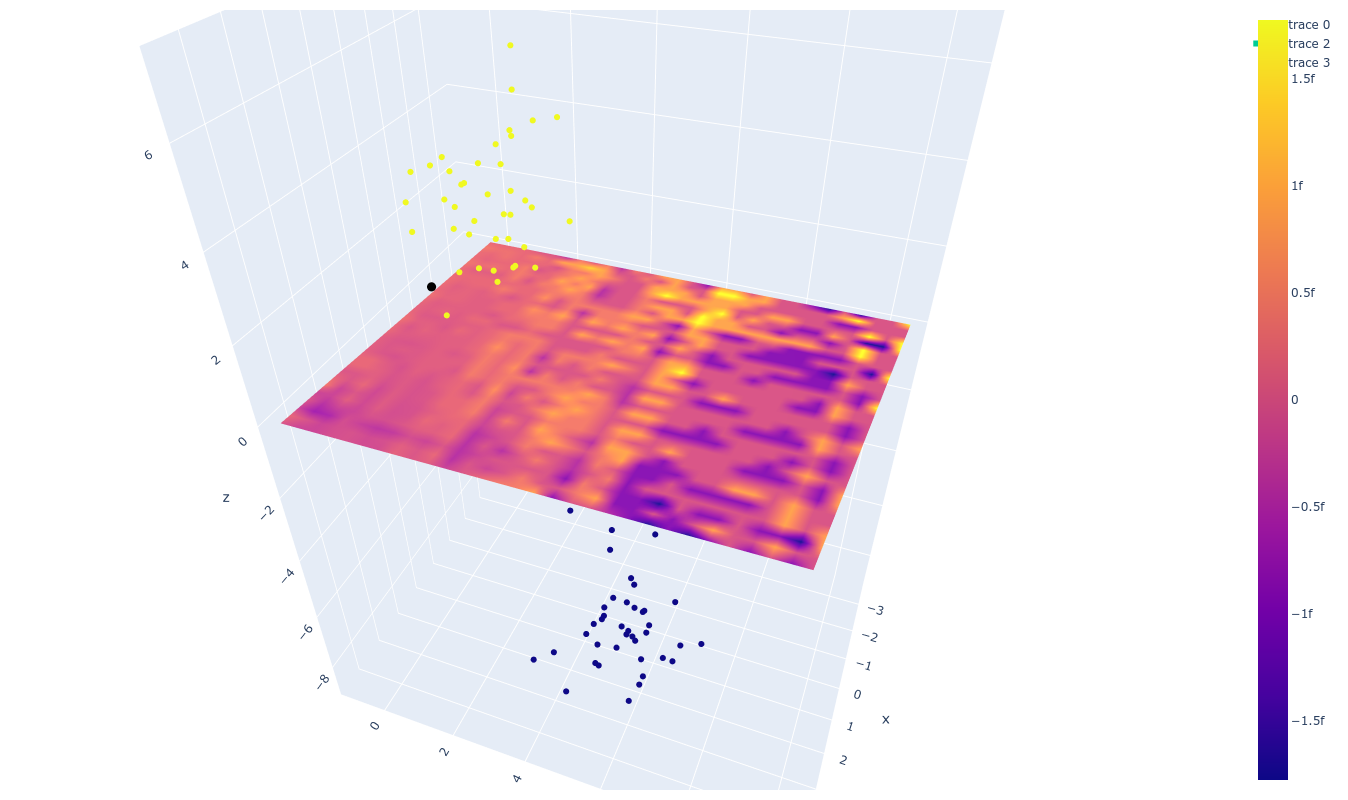

In [32]:
forward, backward = make_base_changer(decision_plane)

with ThreeDFigure(forward, backward, swap_axes="xz") as fig:
    fig.add_markers(X, color=y) #samples
    xx, yy = make_meshgrid(X, margin=1)
    fig.add_surface(xx, yy, decision_plane.z) #decision hyperplane
    fig.add_line(X.mean(axis=0)-decision_plane.normal, X.mean(axis=0)+decision_plane.normal) #orthogonal of decision hyperplane through mean of points
    fig.add_markers([0,0,0], size=3) #coordinate center